In [10]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import metpy.calc as mpcalc
from metpy.units import units
import earthpy.spatial as es

# import personal modules
sys.path.append('../modules') # Path to modules
from preprocess_dataframes import combine_ivt_ar_prec_df
import nclcmaps as nclc
from plotter import draw_basemap

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [2]:
# Set up paths

path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
path_to_work = '/cw3e/mead/projects/cwp140/scratch/dnash/data/preprocessed/SEAK-WRF-PCPT/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [30]:
xs = [-135.4519, -135.3277, -135.8894, -139.671, -133.1358, -132.4009]
ys = [58.1122, 59.4538, 59.3988, 59.5121, 55.4769, 55.5400]
lbl1 = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
lbl_align = ['center', 'left', 'right', 'center', 'right', 'left'] # where the labels go
ext1 = [-141., -130., 54., 61.] # extent of SEAK

# list of extents for each community
dx = 1.5 # this works for our paper
dy = 1.5 # this works for our paper

dx = 0.5 # for supplemental/community partners
dy = 0.5 # for supplemental/community partners

ext_lst = []
for x,y in zip(xs,ys):
    ext_lst.append([x-dx, x+dx, y-dy, y+dy])

ext_lst

[[-135.9519, -134.9519, 57.6122, 58.6122],
 [-135.8277, -134.8277, 58.9538, 59.9538],
 [-136.3894, -135.3894, 58.8988, 59.8988],
 [-140.171, -139.171, 59.0121, 60.0121],
 [-133.6358, -132.6358, 54.9769, 55.9769],
 [-132.9009, -131.9009, 55.04, 56.04]]

In [4]:
## open precipitation and ivt dfs
## append precip to each community IVT df
option = 'a'
temporal_res = 'daily'
community_lst = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']

df_lst = combine_ivt_ar_prec_df(option, temporal_res, community_lst) # combine dfs into list of dfs
df_lst[0]

,time,IVT,lat,lon,uIVT,vIVT,IWV,ivtdir,AR,impact,prec
time,,,,,,,,,,,
1980-01-01,1980-01-01,148.93,58.00,-135.50,29.62,148.30,11.56,211.02,0,0,6.35
1980-01-02,1980-01-02,147.08,58.00,-135.50,6.58,146.94,11.51,186.81,0,0,10.58
1980-01-03,1980-01-03,101.50,58.00,-135.50,26.70,101.25,10.91,257.80,0,0,20.42
1980-01-04,1980-01-04,29.98,58.00,-135.50,21.53,3.76,5.02,357.52,0,0,0.19
1980-01-05,1980-01-05,207.19,58.00,-135.50,200.70,-24.81,10.29,343.00,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,2019-12-27,181.51,58.00,-135.50,83.21,173.45,13.28,236.71,0,1,1.05
2019-12-28,2019-12-28,519.33,58.00,-135.50,173.25,518.97,18.17,222.99,0,0,15.38
2019-12-29,2019-12-29,118.21,58.00,-135.50,43.04,117.63,10.76,208.40,0,0,NaN


In [5]:
## get list of dates that are Extreme Precip and AR for each community
ardate_lst = []
for i, df in enumerate(df_lst):
    prec_thres = df['prec'].describe(percentiles=[.95]).loc['95%'] # 95th percentile precipitation threshold
    # idx = (df.AR == 1) & (df.prec > prec_thres) 
    idx = (df.AR == 1) & (df.prec > prec_thres) & (df.index != '2008-02-29 00:00:00') # hack to get rid of the leap day (not in WRF data)
    tmp = df.loc[idx]
    
    ar_dates = tmp.time.values
    ardate_lst.append(tmp.time.values)

## Load Precipitation Data

In [6]:
fname_pattern = path_to_work + 'WRFDS_PCPT_*.nc'
wrf = xr.open_mfdataset(fname_pattern, combine='by_coords')
if temporal_res == 'hourly':
    wrf = wrf
elif temporal_res == 'daily':
    wrf = wrf.resample(time="1D").sum('time') # resample WRF data to be mm per day
wrf

<xarray.Dataset>
Dimensions:  (time: 14610, y: 250, x: 320)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2019-12-31
    lat      (y, x) float32 dask.array<chunksize=(250, 320), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(250, 320), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    PCPT     (time, y, x) float32 dask.array<chunksize=(1, 250, 320), meta=np.ndarray>
Attributes:
    contact:  rtladerjr@alaska.edu
    info:     Alaska CASC
    data:     Downscaled CFSR
    format:   version 1
    date:     Sat Dec  8 15:40:16 AKST 2018

In [7]:
## Having trouble with wrf ds not having all the dates in the ar_dates list 
## use this to find out which dates are having a problem
# make a pandas dataframe of AR Dates
answer_lst = []
for i, ar_dates in enumerate(ardate_lst):
    d = {'dates': ar_dates}
    df_A = pd.DataFrame(data=d)
    df_A = df_A.set_index(pd.to_datetime(df_A['dates'])) # reset the index as "dates"


    # make a pandas dataframe of WRF dates
    d = {'dates': wrf.time}
    df_B = pd.DataFrame(data=d)
    df_B = df_B.set_index(pd.to_datetime(df_B['dates'])) # reset the index as "dates"

    # test = df_A.isin(df_B)

    x = df_A.index
    y = df_B.index
    test = x.isin(y)

    idx = (test== False)
    answer = df_A.loc[idx]
    answer_lst.append(answer.dates.values)
answer_lst

[array([], dtype='datetime64[ns]'),
 array([], dtype='datetime64[ns]'),
 array([], dtype='datetime64[ns]'),
 array([], dtype='datetime64[ns]'),
 array([], dtype='datetime64[ns]'),
 array([], dtype='datetime64[ns]')]

In [8]:
%%time
## make a dataset for each community subset to its AR dates
ds_lst = []
for i, ar_dates in enumerate(ardate_lst):
    print('Processing {0}'.format(community_lst[i]))
    tmp = wrf.sel(time=ar_dates)
    tmp = tmp.mean('time')
    ds_lst.append(tmp.load())
    
ds_lst[0]

Processing Hoonah
Processing Skagway
Processing Klukwan
Processing Yakutat
Processing Craig
Processing Kasaan
CPU times: user 52.7 s, sys: 10min 17s, total: 11min 10s
Wall time: 17min 31s


<xarray.Dataset>
Dimensions:  (y: 250, x: 320)
Coordinates:
    lat      (y, x) float32 53.12 53.12 53.13 53.13 ... 61.97 61.97 61.96 61.95
    lon      (y, x) float32 -148.1 -148.0 -147.9 -147.9 ... -126.4 -126.3 -126.3
Dimensions without coordinates: y, x
Data variables:
    PCPT     (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

In [11]:
## merge all communities into single DS with "community name" as axis
prec_comp = xr.concat(ds_lst, dim=community_lst)
## calculate average of all 6 communities
prec_mean = prec_comp.mean('concat_dim')

## subtract the mean from the original composites
prec_diff = prec_comp - prec_mean

### Load elevation data

In [14]:
## Open southwest_geo.nc to pull projection information
wrf_elev = xr.open_dataset(path_to_data + 'downloads/geo_southeast.nc')
wrf_elev = wrf_elev.isel(Time=0)
elev = wrf_elev.HGT_M.values
wrflats = wrf_elev.CLAT.values
wrflons = wrf_elev.CLONG.values

# create hillshade 
hillshade = es.hillshade(wrf_elev.HGT_M, azimuth=180, altitude=1)

In [18]:
# fname = path_to_data + 'downloads/ETOPO1_Bed_g_gmt4.grd'
# version = 'bedrock'
# grid = xr.open_dataset(fname, engine='netcdf4')
# # Add more metadata and fix some names
# names = {"ice": "Ice Surface", "bedrock": "Bedrock"}
# grid = grid.rename(z=version, x="lon", y="lat")
# grid[version].attrs["long_name"] = "{} relief".format(names[version])
# grid[version].attrs["units"] = "meters"
# grid[version].attrs["vertical_datum"] = "sea level"
# grid[version].attrs["datum"] = "WGS84"
# grid.attrs["title"] = "ETOPO1 {} Relief".format(names[version])
# grid.attrs["doi"] = "10.7289/V5C8276M"

# etopo = grid.sel(lat=slice(ext1[2], ext1[3]), lon=slice(ext1[0], ext1[1]))
# topolats = etopo.lat
# topolons = etopo.lon
# topo = etopo.bedrock

In [19]:
wrflats

array([[53.119694, 53.124737, 53.129738, ..., 53.129738, 53.124737,
        53.119694],
       [53.15519 , 53.16024 , 53.165253, ..., 53.165253, 53.16024 ,
        53.15519 ],
       [53.19069 , 53.195736, 53.20076 , ..., 53.20076 , 53.195736,
        53.19069 ],
       ...,
       [61.884148, 61.89058 , 61.896973, ..., 61.896973, 61.89058 ,
        61.884148],
       [61.919453, 61.925896, 61.932297, ..., 61.932297, 61.925896,
        61.919453],
       [61.954754, 61.961205, 61.967613, ..., 61.967613, 61.961205,
        61.954754]], dtype=float32)

## Plot Precitation Composites

In [32]:
# Set up projection
mapcrs = ccrs.Mercator()
# mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
lats = wrf.lat.values[:, 0]
lons = wrf.lon.values[0, :]
dx = np.arange(lons.min().round(),lons.max().round()+0.25,+0.25)
dy = np.arange(lats.min().round(),lats.max().round()+0.25,+0.25)

ext1 = [-141., -130., 54., 61.] # extent of SEAK

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

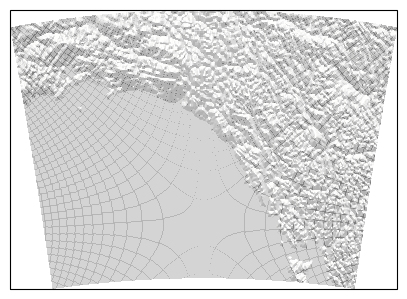

In [33]:
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(1, 1, 1, projection=mapcrs)
fig.set_size_inches(5, 5)
# cf = ax.imshow(hillshade, cmap=cmo.gray, alpha=0.3)
cf = ax.pcolormesh(wrflons, wrflats, hillshade, rasterized=True, cmap=cmo.gray, shading='auto', transform=datacrs, alpha=0.3)



/tmp/ipykernel_2552/4080583946.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(nrows, ncols, k+1, projection=mapcrs)


103.77926
155.81497
156.40555
123.3881
91.381096
71.099174


/cw3e/mead/projects/cwp140/scratch/dnash/miniconda3/envs/SEAK-clim/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/cw3e/mead/projects/cwp140/scratch/dnash/miniconda3/envs/SEAK-clim/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


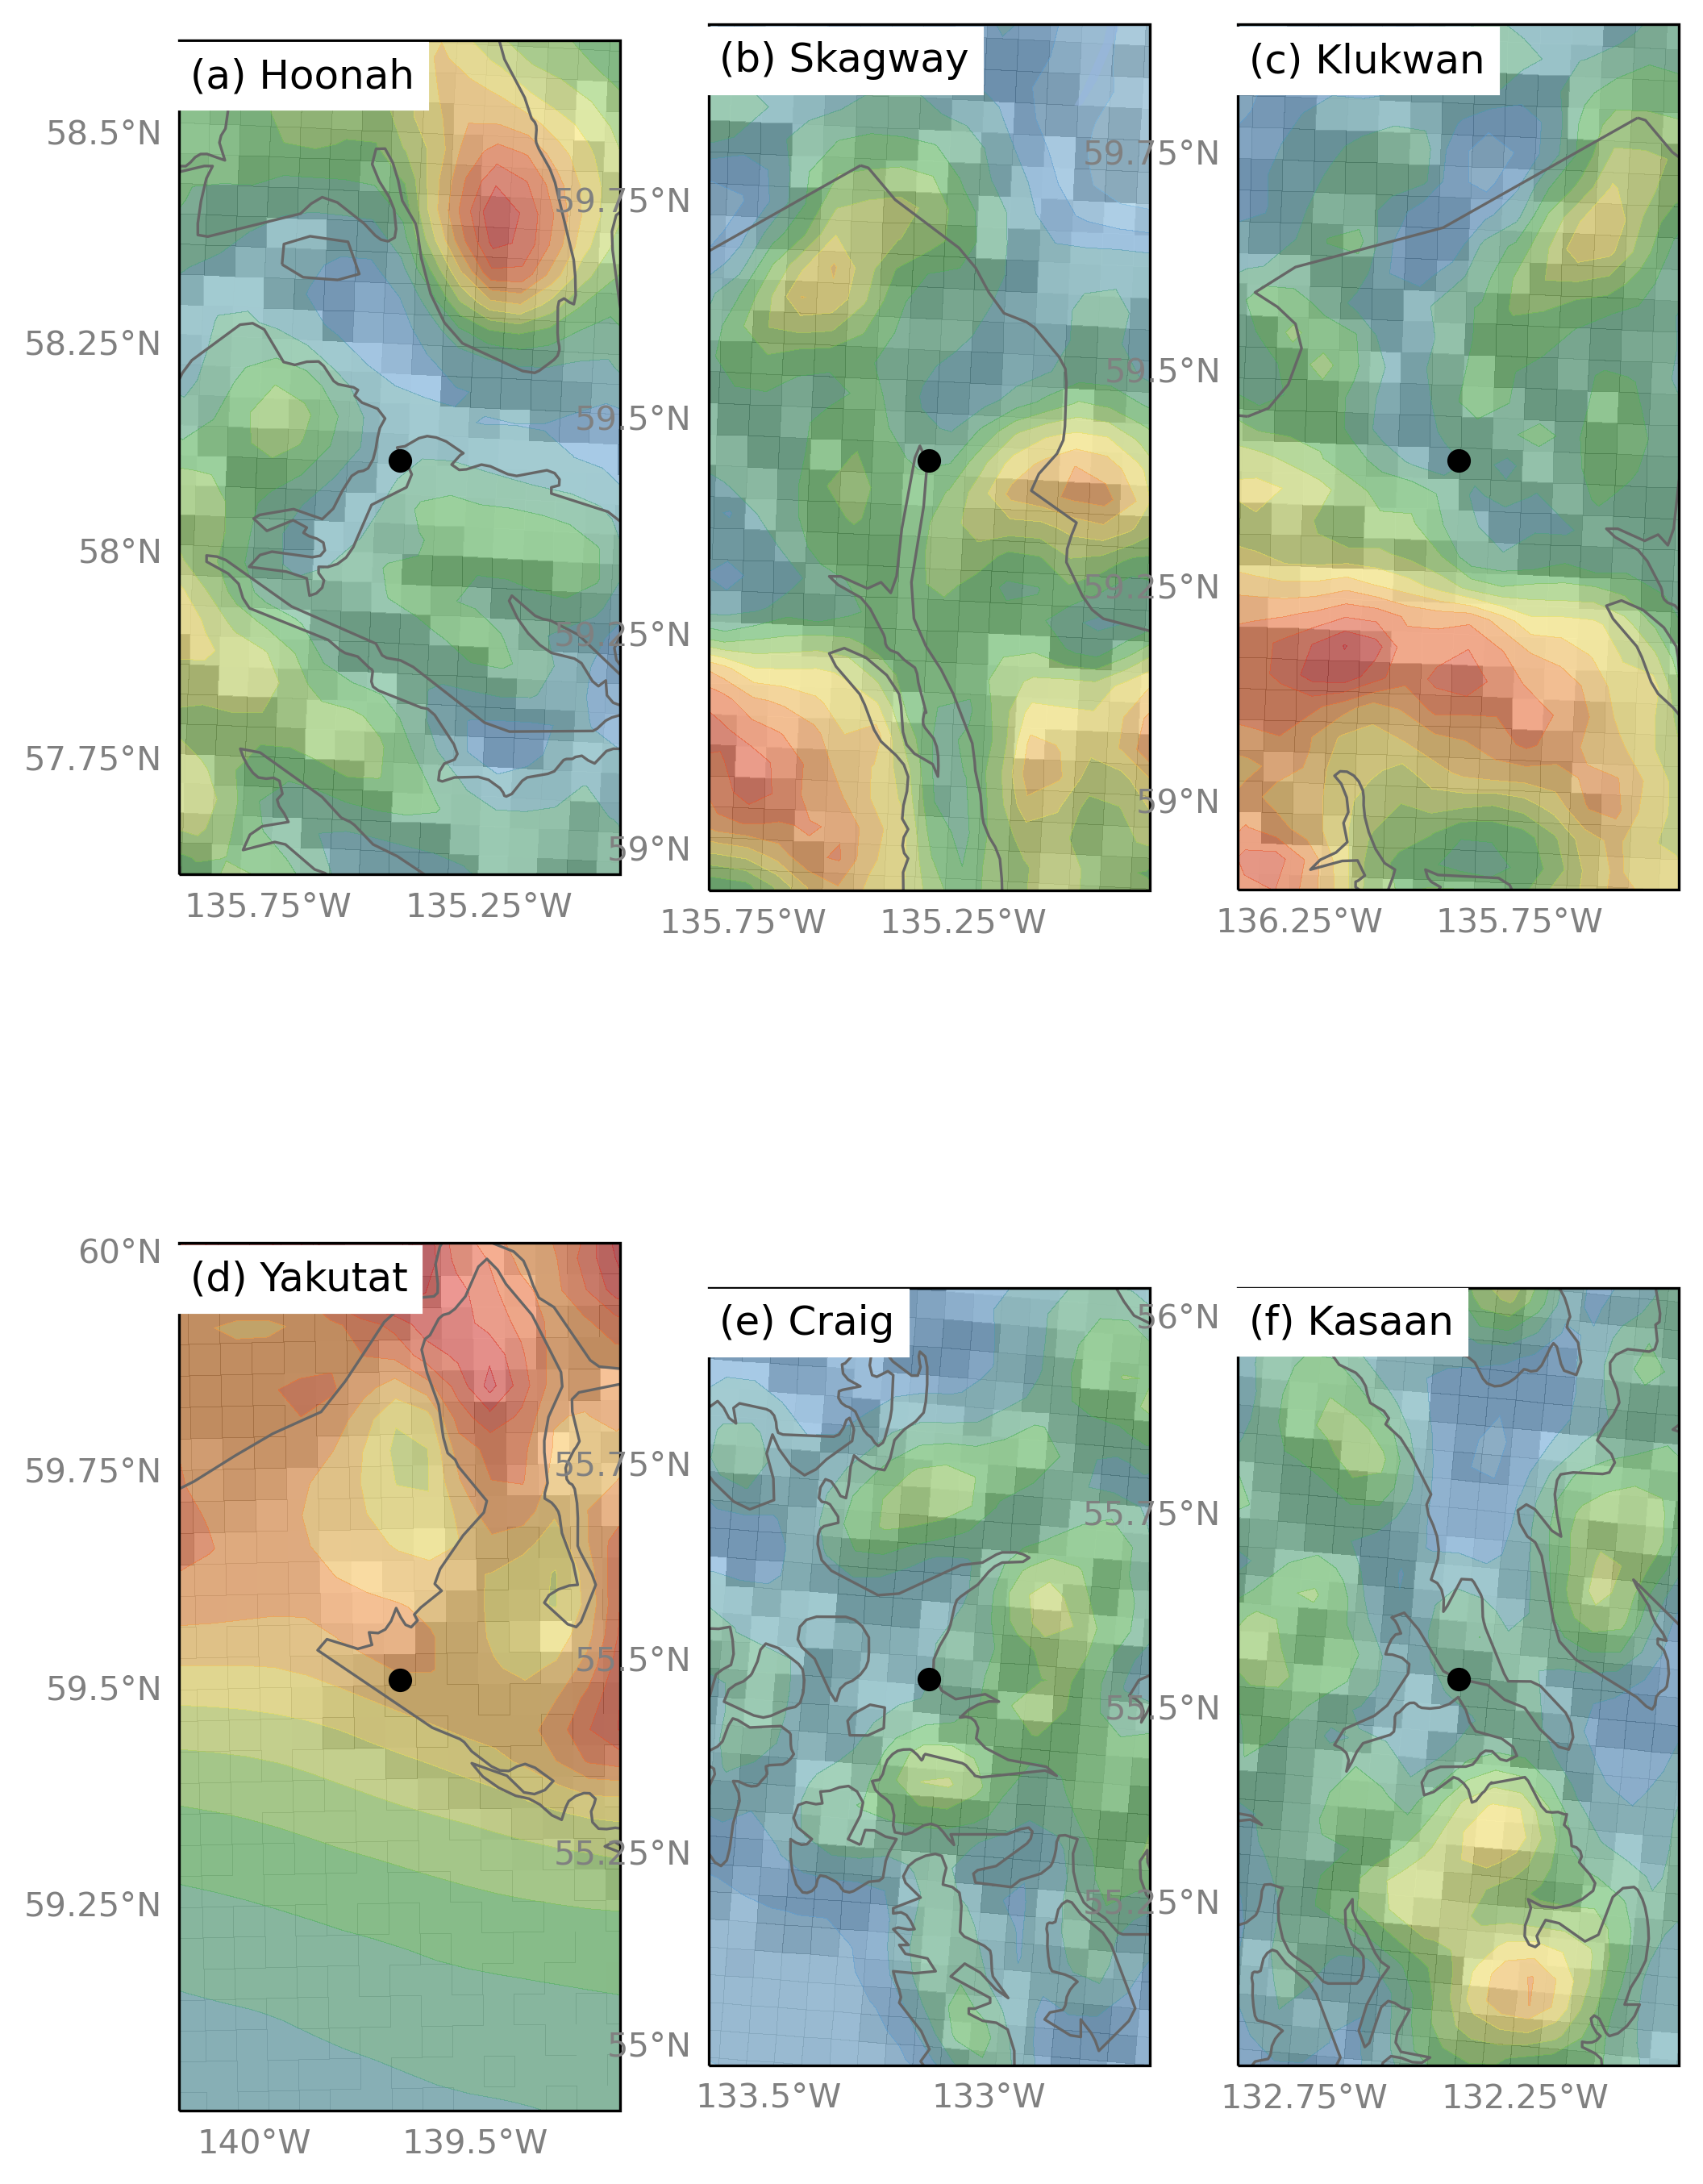

In [35]:
left_lat_lst = [True, False, False, True, False, False]
bottom_lon_lst = [False, False, False, True, True, True]
# Create figure
fig = plt.figure(figsize=(8, 12))
fig.dpi = 300
fname = path_to_figs + 'extreme-AR_prec_composite_all_{0}'.format(temporal_res)
fmt = 'png'

nrows = 2
ncols = 3

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.3,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.35, cbar_size='3%',label_mode='')

# for k, ax in enumerate(axgr):
for k in np.arange(nrows*ncols):
    ax = plt.subplot(nrows, ncols, k+1, projection=mapcrs)
    ds = prec_comp.sel(concat_dim=community_lst[k])
    ax = draw_basemap(ax, extent=ext_lst[k], xticks=dx, yticks=dy,left_lats=True, right_lats=False, bottom_lons=True)
    
    # topo with grey-scale cmap
    # cf = ax.pcolormesh(wrflons, wrflats, elev, rasterized=True, norm=divnorm,
    #                     cmap=cmo.gray, shading='auto', transform=datacrs)
    cs = ax.pcolormesh(wrflons, wrflats, hillshade, rasterized=False, cmap=cmo.gray, shading='auto', transform=datacrs, alpha=0.4)

    # Contour Filled
    prec = ds.PCPT.values
    print(np.nanmax(prec))
    if temporal_res == 'hourly':
        clevs = np.arange(0.1, 2.2, 0.1)
        clabel = 'precipitation (mm hour$^{-1}$)'
    elif temporal_res == 'daily':
        clevs = np.arange(0.0, 105, 5)
        clabel = 'precipitation (mm day$^{-1}$)'
    cf = ax.contourf(ds.lon.values, ds.lat.values, prec, transform=datacrs,
                     levels=clevs, cmap=nclc.cmap('WhiteBlueGreenYellowRed'), alpha=0.5, extend='max')
    
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    
    # # elevation contour
    # clevs=np.array([500, 1000, 2000])
    # cs = ax.contour(wrflons, wrflats, elev, clevs, colors='k', linewidths=0.75,
    #                 linestyles='solid', transform=datacrs)

    titlestring = '({0}) {1}'.format(letter_lst[k], community_lst[k])
    ax.text(0.025, 0.98, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=101)
    # need this to fix annotate transform
    transform = datacrs._as_mpl_transform(ax)

    # Plot Location of community pts
    ax.plot(xs[k], ys[k], 'ko', markersize=6, transform=datacrs)

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=False)
cb.set_label(clabel, fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()

In [ ]:
# Create figure
fig = plt.figure(figsize=(8, 12))
fig.dpi = 300
fname = path_to_figs + 'extreme-AR_prec_composite_{0}_summary'.format(temporal_res)
fmt = 'png'

nrows = 1
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='')


for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,left_lats=True, right_lats=False, mask_ocean=False)

    # Contour Filled
    ds = prec_mean
    print(np.nanmax(prec))
    if temporal_res == 'hourly':
        clevs = np.arange(0.1, 2.2, 0.1)
        clabel = 'precipitation (mm hour$^{-1}$)'
    elif temporal_res == 'daily':
        clevs = np.arange(0.1, 165, 15)
        clabel = 'precipitation (mm day$^{-1}$)'
    cf = ax.contourf(ds.lon.values, ds.lat.values, ds.PCPT.values, transform=datacrs,
                     levels=clevs, cmap=nclc.cmap('WhiteBlueGreenYellowRed'), alpha=0.9, extend='max')
    
    # need this to fix annotate transform
    transform = datacrs._as_mpl_transform(ax)
    
    ## Plot the locations of the focus communities
    # zip joins x and y coordinates in pairs
    for x,y,z,ha in zip(xs,ys, lbl1, lbl_align):

        # Plot Location of pts
        ax.plot(x, y, 'ro', markersize=6, transform=datacrs)

        ax.annotate(z, # this is the text
                   (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,12), # distance from text to points (x,y)
                    ha=ha, # horizontal alignment can be left, right or center
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="k", lw=0.5, alpha=0.8),
                    xycoords=transform,
                    zorder=102,
                    fontsize=14)



# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=False)
cb.set_label(clabel, fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()